### Import your corpus

Wikidata is a collaboratively edited knowledgebase provides a common source of data for Wikipedia.
We use a slice of 500k documents of the 2008 dump

In [1]:
# Install PyDrive
!pip install PyDrive
!pip install pandas
import pandas as pd
#Import modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Get the Shareable link
#Ex BIG : https://drive.google.com/file/d/1aWNJjMp9Ks-ponG8MLpHz6eRYS-gzA4i/view?usp=sharing
#https://drive.google.com/file/d/1pk1ziKJEXs6lEXXIXrEDbVOuvipvpXIH/view?usp=sharing
#https://drive.google.com/file/d/1Jyd_UZgrb45krkxZQndPA59HmC1PKzxG/view?usp=sharing

#ORIGINALE
#https://drive.google.com/file/d/1QEaoJiiCvakAo-zf79gjhK0Aw9GbsdvG/view?usp=sharing
downloaded = drive.CreateFile({'id':"1Jyd_UZgrb45krkxZQndPA59HmC1PKzxG"})   
downloaded.GetContentFile('abstract_cleaned.csv')       

import pandas as pd

df2 = pd.read_csv("abstract_cleaned.csv",encoding  = "UTF-8")

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1QEaoJiiCvakAo-zf79gjhK0Aw9GbsdvG"})   
downloaded.GetContentFile('PAPER2009_to2021.csv')  
df_orig = pd.read_csv("PAPER2009_to2021.csv",encoding  = "UTF-8")

In [3]:
df2

,year,abstract
0,2014,"visual,analytics,inherently,collaboration,huma..."
1,2014,"graph,presented,multi,class,classifier,often,c..."
2,2014,"present,fluxflow,interactive,visual,analysis,s..."
3,2014,"interactive,visualization,provides,valuable,su..."
4,2014,"micrornas,mirnas,family,non,coding,rna,approxi..."
...,...,...
19919,2015,"one,important,task,pattern,machine_learning,da..."
19920,2015,"computational,docking,core,process,computer,ai..."
19921,2015,"mobile,app,smartphones,tablet,document,pressur..."
19922,2015,"eye,disease,diabetic,retinopathy,may,cause,bli..."


In [4]:
df2['Keywords'] = pd.Series(df_orig['Index Keywords'])

### Create embeddings

In [5]:
df2['Keywords'].count()

16644

In [6]:
df2_not_na = df2[~(df2['Keywords'].isna())]

In [7]:
df2_not_na['Keywords'].count()

16644

#### DF processing for tf idf


In [8]:
!pip install nltk
!pip install tqdm
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

stopwords.extend(['present','however','springer','compared','better','online','education','experimental',
                  'domain','several','many','right','important','applied','first','three','order','various'
                  'advanced','neuroscience','forecasted','forecasting','support_vector_machinesvm','artificially'
                  ,'disciplinary','contributing','innovative','forum','example','republicationredistribution','approach'
                  ,'neighbour','deformable','dynamic','significantly','contributing','artificially'
                  'artwork', 'architectural', 'architecture','suit','ieee','female','human','humans'
                  'task', 'result', 'set', 'machine', 'analysis', 'paper', 'application', 'approach',
                  'problem', 'set', 'vector', 'function', 'classification_','elsevier','use','user',
                  'article','controlled_study','nan', 'of_information', 'classification_', 'human', 
                  'algorithms', 'algorithm','optimization', 'priority_journal', 'vectors', 'female', 'models',
                  'benchmarking', 'diagnosis', 'procedures', 'also','task', 'result', 'set', 'machine',
                  'analysis', 'paper', 'application', 'approach', 'problem', 'vector', 'function',
                  'selection', 'kernel', 'using', 'based', 'used', 'time', 'new', 'study', 'two', 'one' ,
                  'show' ,'image', 'data', 'system','model', 'method', 'feature', 'proposed', 'performance',
                  'information', 'different','protein','toward','proactive','class','research',
                  'computer','processing','artificial','process','pattern','real','multi','and',
                  'well','large','work','number', "framework", "number", "level" "space","solution","rule", "error", "structure"])


text_0 = df2_not_na['Keywords']
df_tf_idf = text_0.str.split(";")
df_tf_idf = df_tf_idf.apply(lambda x: [item.replace('[^\w\s]',' ')  for item  in x])
df_tf_idf = df_tf_idf.apply(lambda x: [str(item).strip()   for item  in x])
df_tf_idf = df_tf_idf.apply(lambda x: [str(item).replace(",", "")  for item  in x])
df_tf_idf = df_tf_idf.apply(lambda x: [str(item).lower()  for item in x])
df_tf_idf = df_tf_idf.apply(lambda x: [lemmatizer.lemmatize(item) for item in x])
df_tf_idf = df_tf_idf.apply(lambda x: [item.replace("-", " ") for item in x ] )
df_tf_idf = df_tf_idf.apply(lambda x: [item.replace(" ", "_") for item in x ] )
#df_tf_idf = df_tf_idf.apply(lambda x: [item for item in x if item not in stopwords] )

keywords = []

for row in df_tf_idf:
    keywords.append(','.join([item for item in row if item not in stopwords]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
abstract_0 = df2_not_na['abstract']
abstract = abstract_0.apply(lambda x: x.split(","))
abstract = abstract.apply(lambda x: [item.replace('[^\w\s]',' ')  for item  in x])
abstract = abstract.apply(lambda x: [item.strip()   for item  in x])
abstract = abstract.apply(lambda x: [item.lower()  for item in x])
abstract = abstract.apply(lambda x: [lemmatizer.lemmatize(item) for item in x])
#abstract = abstract.apply(lambda x: [item for item in x if item not in stopwords] )


abs = []
for row in abstract:
    abs.append(','.join([item for item in row if item not in stopwords]))

In [10]:
df2_not_na['abstract'] = abs
df2_not_na['Keywords'] = keywords

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
abstract[0]

['visual',
 'analytics',
 'inherently',
 'collaboration',
 'human',
 'computer',
 'however',
 'current',
 'visual',
 'analytics',
 'system',
 'computer',
 'limited',
 'mean',
 'knowing',
 'user',
 'analysis',
 'process',
 'existing',
 'research',
 'shown',
 'user',
 'interaction',
 'system',
 'reflect',
 'large',
 'amount',
 'user',
 'reasoning',
 'process',
 'limited',
 'advancement',
 'developing',
 'automated',
 'real',
 'time',
 'technique',
 'mine',
 'interaction',
 'learn',
 'user',
 'paper',
 'demonstrate',
 'accurately',
 'predict',
 'user',
 'task',
 'performance',
 'infer',
 'user',
 'personality',
 'trait',
 'using',
 'machine_learning_techniques',
 'analyze',
 'interaction',
 'data',
 'specifically',
 'conduct',
 'experiment',
 'participant',
 'perform',
 'visual',
 'search',
 'task',
 'apply',
 'well',
 'known',
 'machine_learning_algorithms',
 'three',
 'encoding',
 'user',
 'interaction',
 'data',
 'achieve',
 'depending',
 'algorithm',
 'encoding',
 'accuracy',
 'predic

In [12]:
abs[0]

'visual,analytics,inherently,collaboration,current,visual,analytics,limited,mean,knowing,existing,shown,interaction,reflect,amount,reasoning,limited,advancement,developing,automated,technique,mine,interaction,learn,demonstrate,accurately,predict,infer,personality,trait,machine_learning_techniques,analyze,interaction,specifically,conduct,experiment,participant,perform,visual,search,apply,known,machine_learning_algorithms,encoding,interaction,achieve,depending,encoding,accuracy,predicting,whether,fast,slow,completing,beyond,predicting,demonstrate,technique,infer,aspect,personality,factor,including,locus,control,extraversion,neuroticism,strong,attained,limited,observation,case,final,accuracy,gained,quarter,average,completion,overall,finding,interaction,provide,collaborator,establish,foundation,realizing,mixed,initiative,visual,analytics'

In [13]:
df2_not_na['text'] = df2_not_na['abstract'] + ',' + df2_not_na['Keywords']
df2_not_na

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,year,abstract,Keywords,text
0,2014,"visual,analytics,inherently,collaboration,curr...","analytic_provenance,applied_machine_learning,u...","visual,analytics,inherently,collaboration,curr..."
1,2014,"graph,presented,classifier,often,compute,score...","confusion_analysis,feature_evaluation_and_sele...","graph,presented,classifier,often,compute,score..."
2,2014,"fluxflow,interactive,visual,revealing,analyzin...","anomaly_detection,information_visualization,re...","fluxflow,interactive,visual,revealing,analyzin..."
3,2014,"interactive,visualization,provides,valuable,su...","distant_readings,document_analysis,literary_an...","interactive,visualization,provides,valuable,su..."
4,2014,"micrornas,mirnas,family,non,coding,rna,approxi...","amino_acids,artificial_intelligence,feature_ex...","micrornas,mirnas,family,non,coding,rna,approxi..."
...,...,...,...,...
19918,2015,"medium,sharing,flickr,panoramio,contain,amount...","event_retrieval,query_expansion,social_media,s...","medium,sharing,flickr,panoramio,contain,amount..."
19919,2015,"machine_learning,data_mining,classification,in...","artificial_intelligence,clustering_algorithms,...","machine_learning,data_mining,classification,in..."
19920,2015,"computational,docking,core,aided,drug,design,c...","artificial_intelligence,binder,binding_energy,...","computational,docking,core,aided,drug,design,c..."
19921,2015,"mobile,app,smartphones,tablet,document,pressur...","artificial_intelligence,camera,color,expert_sy...","mobile,app,smartphones,tablet,document,pressur..."


In [14]:
#from gensim.models.phrases import Phrases
#bigram = Phrases(df_tf_idf, min_count=3, threshold=0.2)


In [15]:
#print(bigram[df_tf_idf[5]])

In [16]:
#bigrams = [bigram[item] for item in df_tf_idf] 
#ngrams = [bigram[item] for item in bigrams] 

In [17]:
"""
corpus = []
for row in ngrams:
    corpus.append(' '.join([item for item in row if item not in stopwords]))
"""

"\ncorpus = []\nfor row in ngrams:\n    corpus.append(' '.join([item for item in row if item not in stopwords]))\n"

corpus[0]

In [18]:
"""
corpus_txt = []
for item in corpus:
  corpus_txt.append(item.replace(",", " "))
  """

'\ncorpus_txt = []\nfor item in corpus:\n  corpus_txt.append(item.replace(",", " "))\n  '

In [19]:
text = df2_not_na['text']



In [20]:
!pip install spacy
import spacy
import re
import tqdm

nlp = spacy.load('en_core_web_sm') #you can use other methods
# excluded tags
excluded_tags = {"VERB","ADJ","ADV", "ADP", "PROPN","CCONJ","DET"}
document = [line.strip() for line in text]

sentences = document[:] 
new_sentences = []
for sentence in sentences:
  new_sentence = []
  sentence.replace(",", " ")
  for token in nlp(sentence):
      if token.pos_ not in excluded_tags:
          new_sentence.append(token.text)
  new_sentence = re.sub(",,+", ",", "".join(new_sentence))
  new_sentence = new_sentence.strip(",")
  new_sentences.append(new_sentence)

In [21]:
sentences[0]

'visual,analytics,inherently,collaboration,current,visual,analytics,limited,mean,knowing,existing,shown,interaction,reflect,amount,reasoning,limited,advancement,developing,automated,technique,mine,interaction,learn,demonstrate,accurately,predict,infer,personality,trait,machine_learning_techniques,analyze,interaction,specifically,conduct,experiment,participant,perform,visual,search,apply,known,machine_learning_algorithms,encoding,interaction,achieve,depending,encoding,accuracy,predicting,whether,fast,slow,completing,beyond,predicting,demonstrate,technique,infer,aspect,personality,factor,including,locus,control,extraversion,neuroticism,strong,attained,limited,observation,case,final,accuracy,gained,quarter,average,completion,overall,finding,interaction,provide,collaborator,establish,foundation,realizing,mixed,initiative,visual,analytics,analytic_provenance,applied_machine_learning,user_interaction,flow_visualization,adolescent,adult,computer_graphics,computer_interface,decision_making,ima

In [22]:
new_sentences[0]

'analytics,collaboration,analytics,interaction,reflect,amount,reasoning,advancement,technique,mine,interaction,infer,personality,trait,machine_learning_techniques,analyze,interaction,conduct,experiment,participant,search,machine_learning_algorithms,encoding,interaction,encoding,accuracy,whether,demonstrate,technique,infer,aspect,personality,factor,locus,control,extraversion,neuroticism,observation,case,accuracy,quarter,average,completion,finding,interaction,collaborator,establish,foundation,realizing,initiative,analytics,analytic_provenance,flow_visualization,adult,computer_graphics,personality,adult,computer_graphics,personality,task_performance_and_analysis,user_computer_interface'

In [23]:
type(new_sentences)

list

In [24]:
corpus = []
for row in new_sentences:
    corpus.append(row.replace(",", " "))
df2_not_na["abstract_spacy"] = corpus

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
from gensim.models.phrases import Phrases
bigram = Phrases(corpus, min_count=3, threshold=0.2)
bigrams = [bigram[item] for item in df_tf_idf] 
ngrams = [bigram[item] for item in bigrams] 
ngrams_ = [",".join(item) for item in ngrams]

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, stop_words=stopwords, ngram_range=(1, 2))
X = tfidf.fit_transform(ngrams_)
df1 = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names())

In [56]:
df_sort =None
df_sort = df1.T.sum(axis=1)

In [122]:
df_sort.to_csv("worldCloud.csv")

In [57]:
df_sort.sort_values(ascending=False)[0:30]           


learning_systems                        1053.235072
artificial_intelligence                  811.651610
machine_learning                         749.646156
learning_algorithms                      656.023589
support_vector_machines                  518.821294
data_mining                              382.792574
learning_algorithms learning_systems     343.084439
neural_networks                          340.532196
feature_extraction                       318.079035
machine_learning_techniques              316.532246
extreme_learning_machine                 314.505794
deep_learning                            272.662479
decision_trees                           269.958556
knowledge_acquisition                    248.096097
regression_analysis                      231.943538
support_vector_machine                   226.590632
machine_learning_methods                 222.325618
supervised_learning                      210.627050
pattern_recognition                      207.786414
semantics   

In [115]:
tf_idf_df = df_sort.sort_values(ascending=False)[:30].index.tolist()
tf_idf_df

['text_processing',
 'face_recognition',
 'image_classification',
 'software',
 'problem_solving',
 'image_retrieval',
 'methodology',
 'complex_networks',
 'accuracy',
 'information_retrieval',
 'behavioral_research',
 'speech_recognition',
 'scheduling',
 'nearest_neighbor_search',
 'learning_algorithm',
 'evolutionary_algorithms',
 'extraction',
 'stochastic_systems',
 'convolution',
 'image_analysis',
 'sensitivity_and_specificity',
 'convolutional_neural_network',
 'matrix_algebra',
 'network_layers',
 'probability',
 'chemistry',
 'state_of_the_art',
 'quality_control',
 'generalization_performance',
 'animal']

In [61]:
df2_not_na["abstract_spacy"] = None
df2_not_na["abstract_spacy"] = ngrams_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
corpus_abstract = None
corpus_abstract = df2_not_na["abstract_spacy"].str.split(",")

In [84]:
from gensim.models import FastText
%time ft_model_cb = FastText(sg=0, sentences=corpus_abstract, size=10, window=5, min_count=10, iter=5, min_n=5, max_n=6)
%time ft_model_sg = FastText(sg=0, sentences=corpus_abstract, size=10, window=4, min_count=10, iter=5, min_n=5, max_n=6)

CPU times: user 15.6 s, sys: 46.6 ms, total: 15.7 s
Wall time: 8.8 s
CPU times: user 14.1 s, sys: 47.8 ms, total: 14.1 s
Wall time: 8 s


In [104]:
from gensim.models import KeyedVectors 
ft_model_cb.wv.save_word2vec_format('ft_model_cb.vec', binary=False)
ft_model_sg.wv.save_word2vec_format('ft_model_sg.vec', binary=False)

#### import w2v and fastText and train a vector model

In [ ]:
from gensim.models import FastText

models = []
for i in range(5,6):
  model_name_cb = "ft_model_cb_"+str(i)+'.vec'
  model_name_sg = "ft_model_sg_"+str(i)+'.vec'
  model_name_cb = FastText(sg=0, sentences=corpus_abstract, size=10, window=i, min_count=5, iter=5, min_n=5, max_n=6)
  model_name_sg = FastText(sg=1, sentences=corpus_abstract, size=10, window=i, min_count=5, iter=5, min_n=5, max_n=6)
  models.append(model_name_cb)
  models.append(model_name_sg)
  ft_model.wv.save_word2vec_format(model_name_cb, binary=False)
  ft_model.wv.save_word2vec_format(model_name_sg, binary=False)


#### Save Model to File

In [89]:
ft_model_cb.most_similar('machine_learning', topn = 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('applied_machine_learning', 0.9698399305343628),
 ('hybrid_machine_learning', 0.9392151832580566),
 ('learning_automata', 0.9099183678627014)]

In [117]:
ft_model_sg.most_similar('machine_learning', topn = 3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('applied_machine_learning', 0.9698399305343628),
 ('hybrid_machine_learning', 0.9392151832580566),
 ('learning_automata', 0.9099183678627014)]

In [ ]:
output_list = []
for i in tf_idf_df:
  for j in range(0,3):
    output_list.append(ft_model_cb.most_similar(i, topn = 3)[j][0])
  output_list.append(i)

In [91]:
output_list

['knowledge_transfer',
 'hierarchical_systems',
 'network_routing',
 'learning_systems',
 'artificial_intelligent',
 'automata_theory',
 'computer_science',
 'artificial_intelligence',
 'applied_machine_learning',
 'hybrid_machine_learning',
 'machine_learning_literature',
 'machine_learning',
 'online_learning_algorithms',
 'training_algorithms',
 'machine_learning_algorithms',
 'learning_algorithms',
 'twin_support_vector_machines',
 'proximal_support_vector_machines',
 'support_vector_machine_(svms)',
 'support_vector_machines',
 'bioinformatics',
 'web_mining',
 'mining',
 'data_mining',
 'learning_algorithms',
 'trees_(mathematics)',
 'mathematical_transformations',
 'learning_algorithms learning_systems',
 'bp_neural_networks',
 'spiking_neural_networks',
 'wavelet_neural_networks',
 'neural_networks',
 'features_extraction',
 'feature_extractor',
 'extracting_features',
 'feature_extraction',
 'machine_learning_approaches',
 'machine_learning_communities',
 'machine_learning_mod

In [92]:
import pandas as pd
import math

def tranform(z):
    return math.floor(z / 4)

out_df = pd.DataFrame(output_list, columns=["word"])
out_df["index"] = out_df.index
out_df["cat"] = out_df["index"].apply(lambda x: tranform(x))


In [118]:
from gensim.models import KeyedVectors 
import os
from sklearn.metrics import silhouette_score

wn = out_df
with open ('silhouette_grid.csv', 'w') as file:
    file.write('model,silhouette\n')
    for filename in os.listdir('model'):
      model = KeyedVectors.load_word2vec_format('model/'+filename, binary=False)
      in_vocab = [True if word in model.wv.vocab else False for word in wn.word]
      wn['in_vocab'] = in_vocab
      wn_in_vocab = wn[wn['in_vocab']==True]
      vectors = [model[i] for i in wn_in_vocab['word']]
      sil = silhouette_score(vectors, wn_in_vocab['cat'])
      print(f'{filename}: sil={sil}')
      file.write(f'{filename},{sil}\n')
file.close()

ft_model_cb.vec: sil=0.234257772564888
ft_model_sg.vec: sil=0.22233004868030548


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


es. per la sw analyst trovo parole che non esistono nella tassonomia come "application support engineer" lo score è una media tra la cosine similarity e quante volte appare negli annunci

> Blocco con rientro



### Visualise embeddings with UMAP

[UMAP](https://umap-learn.readthedocs.io/en/latest/): Uniform Manifold Approximation and Projection for Dimension Reduction

In [97]:
# !conda install -c conda-forge umap-learn
!pip install umap-learn

#### Define a function to restrict vocab to keywords to speed up UMap

In [99]:
 def restrict_w2v(w2v, restricted_word_set):
    w2v.most_similar(list(restricted_word_set)[0]) #to inizialize norms
    new_vectors = []
    new_vocab = {}
    new_index2entity = []
    new_vectors_norm = []

    for i in range(len(w2v.vocab)):
        word = w2v.index2entity[i]
        vec = w2v.vectors[i]
        vocab = w2v.vocab[word]
        vec_norm = w2v.vectors_norm[i]
        if word in restricted_word_set:
            vocab.index = len(new_index2entity)
            new_index2entity.append(word)
            new_vocab[word] = vocab
            new_vectors.append(vec)
            new_vectors_norm.append(vec_norm)

    w2v.vocab = new_vocab
    w2v.vectors = np.array(new_vectors)
    w2v.index2entity = np.array(new_index2entity)
    w2v.index2word = np.array(new_index2entity)
    w2v.vectors_norm = np.array(new_vectors_norm)

#### Create umap of your vocab

### plot worndet by category

In [114]:
words_categories = out_df
words_categories.to_csv("words_categories.csv", index= False)

In [108]:
#wn_plot = pd.read_csv('output_list_cat5.csv',";")
wn_plot = out_df
ft_imported_model = KeyedVectors.load_word2vec_format('models/ft_model_cb.vec', binary=False)

In [109]:
!pip install adjustText
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
from adjustText import adjust_text
random.seed(42)
plt.rcParams['figure.figsize'] = 25, 12

import umap

import numpy as np
def train_umap(model):
    random.seed(42)
    np.random.seed(42)
    X = model[model.wv.vocab]
    reducer = umap.UMAP(n_neighbors=200, metric='cosine', learning_rate=0.01,
                        n_epochs=2000, spread=5, min_dist=0.5, random_state=42)
    X = model[model.wv.vocab]
    embedding = reducer.fit_transform(X)

    df = pd.DataFrame(embedding)
    df['token'] = model.wv.vocab
    df.columns  = ['x', 'y', 'token']
    return df


word_set = {w for w in output_list if w in ft_imported_model.vocab}
restrict_w2v(ft_imported_model, word_set)
wn_umap = train_umap(ft_imported_model)
wn_umap



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1679: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "
/

,x,y,token
0,2.625470,10.371402,learning_systems
1,-5.299540,-2.851789,artificial_intelligence
2,16.011192,6.363476,machine_learning
3,5.680719,14.882143,learning_algorithms
4,6.248384,-2.703637,support_vector_machines
...,...,...,...
107,1.825787,15.137861,fuzzy_c_means_clustering_algorithms
108,2.625282,16.071985,scalable_algorithms
109,-4.936157,1.074312,boosted_decision_trees
110,5.890607,5.702841,fully_connected_neural_network


In [111]:
import matplotlib
from matplotlib.pyplot import cm

cat_unique = list(wn_plot.cat.unique())
n_cat = len(cat_unique)

markers = [".", "o" ,"v" , "x" , "+" , "1" , "d" , "h" , "|" , "8" , "s" , "p" , "P" , "*" , ">" ,
           "3" , "H" , "<" , "^" , "X" , "D" , "2" , "4" , "_", "D", "d", "X", ",","o","v","1","x"]


markers = markers[:n_cat-1]
    
colors = list(matplotlib.colors.cnames.keys())
colors=cm.rainbow(np.linspace(0,1,n_cat))

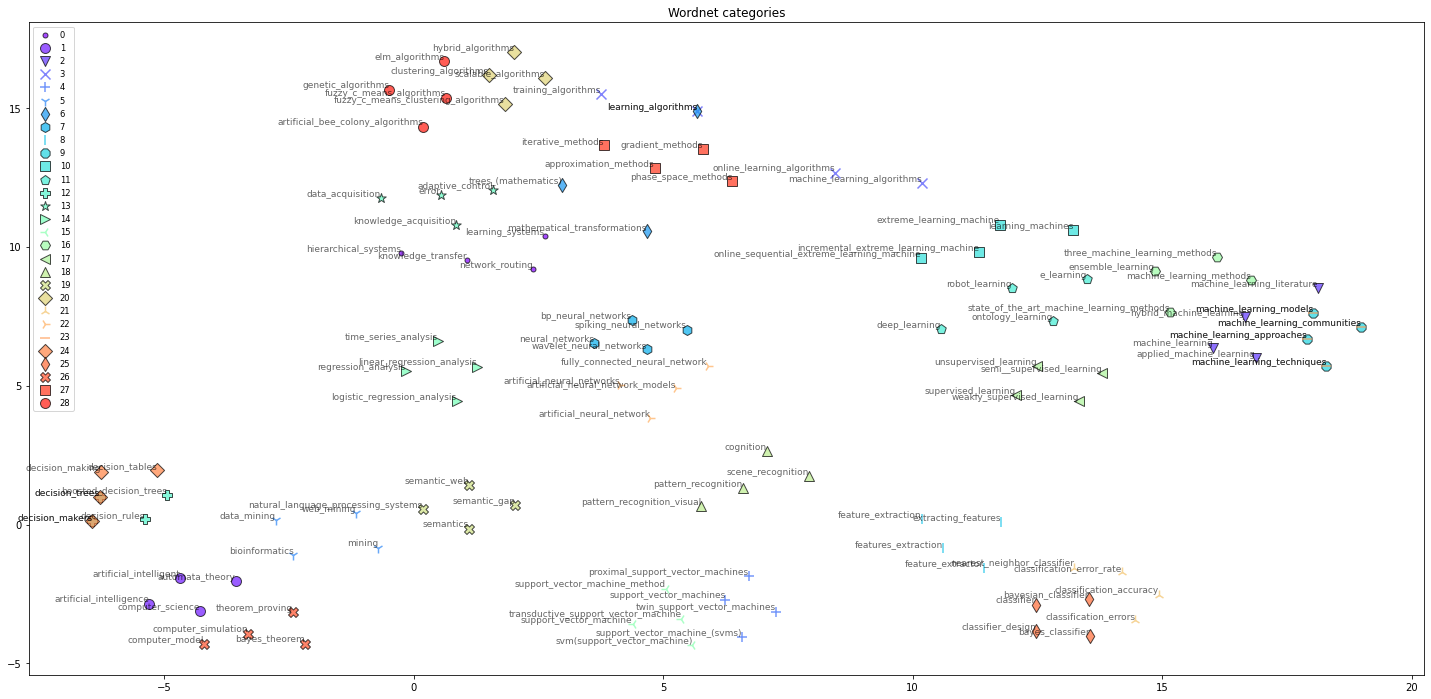

In [126]:
text = []
for cat, color, marker in zip(cat_unique, colors, markers):
    keys = wn_plot['word'][wn_plot['cat'] == cat].values
    top_tfidf_words = wn_umap[wn_umap['token'].isin(keys)]
    if not top_tfidf_words.empty:
        i = 0
        for index,row in top_tfidf_words.iterrows():
            i+=1 #alpha quanto è trasp il colore,e per label
            plt.scatter(row['x'], row['y'], c=np.array([color]), alpha=0.7, label=cat if i == 1 else "", 
                        marker=marker, s=100, edgecolors='black')
            text.append(plt.annotate(row['token'], alpha=0.6, xy=(row['x'], row['y']), ha='right', va='bottom', size=9))
# adjust_text(text)
plt.legend(fontsize='small', loc=2)
plt.title('Wordnet categories')
fig1 = plt.gcf()
plt.show()

In [127]:
plt.draw()
fig1.savefig('WordnetCategorie.png', dpi=100)



<Figure size 1800x864 with 0 Axes>